# Sample Canon Analysis

## Select Image & Phantom and Parse

In [2]:
from pyquantus.parse.canon import canonIqParser, findPreset

In [3]:
# Inputs
imagePath = "/Volumes/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/001/Preset_2/20220427104128_IQ.bin"
phantomPath = "/Volumes/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/Phantom data/Preset_2/20220831121752_IQ.bin"

In [4]:
imPreset = findPreset(imagePath)
phantomPreset = findPreset(phantomPath)
assert imPreset == phantomPreset

In [5]:
imgDataStruct, imgInfoStruct, refDataStruct, refInfoStuct = canonIqParser(imagePath, phantomPath)

/Users/davidspector/Home/Stanford/QuantUS Projects/QuantUS/.venv/lib/python3.11/site-packages/pyquantus/parse/canon.py:77: RuntimeWarning: divide by zero encountered in log10
  bmode = 20*np.log10(abs(iq))


## ROI Selection (from GUI)

In [6]:
import pickle

pkl_name = "/Volumes/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/001/ROIs/20220427104128_IQ/high.pkl"

with open(pkl_name, "rb") as f:
    roi_info = pickle.load(f)

/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_12353/2038082792.py:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  roi_info = pickle.load(f)


In [7]:
from pathlib import Path

assert roi_info["Image Name"] == Path(imagePath).name
assert roi_info["Phantom Name"] == Path(phantomPath).name

In [8]:
scSplineX = roi_info["Spline X"]
scSplineY = roi_info["Spline Y"]

## Analysis Config (from GUI)

In [9]:
from pyquantus.qus import AnalysisConfig

pkl_name = Path("/Volumes/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/analysisConfig.pkl")

with open(pkl_name, "rb") as f:
    config_info = pickle.load(f)

In [10]:
config = config_info["Config"]

## Spectral Analysis

In [11]:
from pyquantus.qus import SpectralAnalysis, UltrasoundImage

In [12]:
ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfoStruct.depth / imgDataStruct.rf.shape[0]
ultrasoundImage.lateralResRf = ultrasoundImage.axialResRf * (
    imgDataStruct.rf.shape[0]/imgDataStruct.rf.shape[1]
) # placeholder
ultrasoundImage.bmode = imgDataStruct.scBmodeStruct.preScArr
ultrasoundImage.phantomRf = refDataStruct.rf
ultrasoundImage.rf = imgDataStruct.rf
ultrasoundImage.scBmode = imgDataStruct.scBmode
ultrasoundImage.xmap = imgDataStruct.scBmodeStruct.xmap
ultrasoundImage.ymap = imgDataStruct.scBmodeStruct.ymap

In [13]:
spectralAnalysis = SpectralAnalysis()
spectralAnalysis.ultrasoundImage = ultrasoundImage
spectralAnalysis.config = config
spectralAnalysis.initAnalysisConfig()
spectralAnalysis.scSplineX = scSplineX
spectralAnalysis.scSplineY = scSplineY

In [14]:
spectralAnalysis.splineToPreSc()
spectralAnalysis.generateRoiWindows()
spectralAnalysis.computeSpecWindows()

In [15]:
print(spectralAnalysis.attenuationCoef, spectralAnalysis.attenuationCorr)

-0.25846134716553437 0.27054767172911304


In [16]:
spectralAnalysis.backScatterCoef

np.float64(0.00764266749485224)

In [17]:
spectralAnalysis.nakagamiParams

(np.float64(2.4660738650904923), np.float64(0.23911688258376726))

In [18]:
print(spectralAnalysis.effectiveScattererDiameter, spectralAnalysis.effectiveScattererConcentration)

1.4321887874843748e-07 72496673220532.72


# Visualizations

In [19]:
import matplotlib.pyplot as plt

from pyquantus.qus import SpectralData
from pyquantus.parse.objects import ScConfig

In [20]:
scConfig = ScConfig()
scConfig.width = imgInfoStruct.width1
scConfig.tilt = imgInfoStruct.tilt1
scConfig.startDepth = imgInfoStruct.startDepth1
scConfig.endDepth = imgInfoStruct.endDepth1

In [21]:
spectralData = SpectralData()
spectralData.spectralAnalysis = spectralAnalysis
spectralData.scConfig = scConfig

In [22]:
spectralData.convertImagesToRGB()

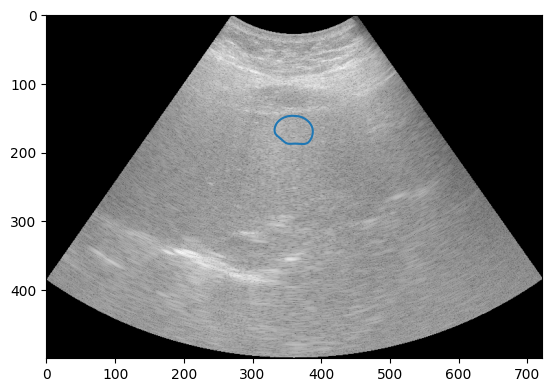

In [23]:
plt.imshow(spectralData.scBmode)
plt.plot(scSplineX, scSplineY)

In [24]:
spectralData.drawCmaps()
spectralData.scanConvertCmaps()

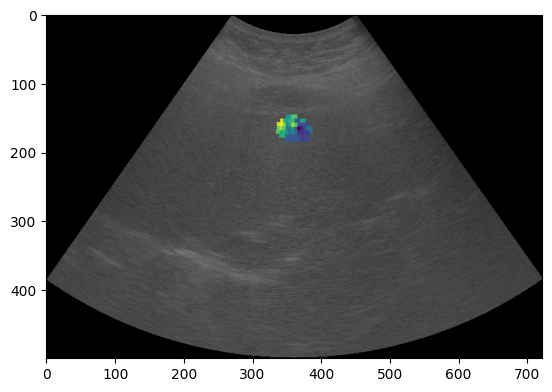

In [25]:
plt.imshow(spectralData.scMbfIm)

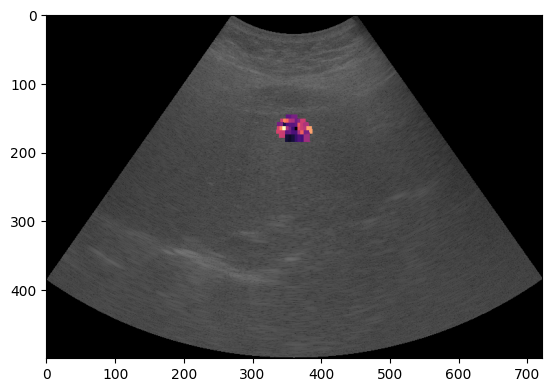

In [26]:
plt.imshow(spectralData.scSsIm)

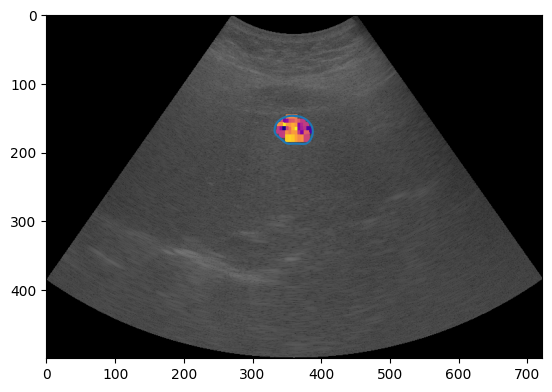

In [27]:
plt.imshow(spectralData.scSiIm)
plt.plot(spectralData.splineX, spectralData.splineY)

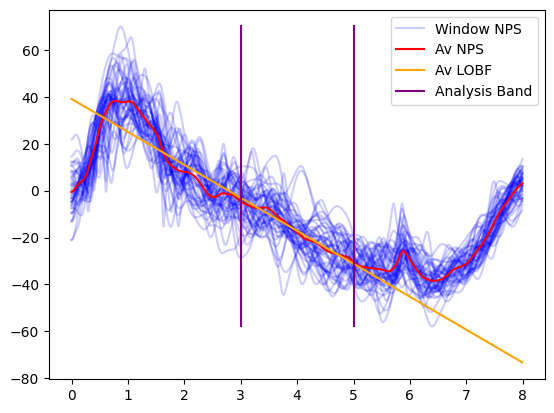

In [28]:
spectralData.plotPsData()